# Feature Selection

In [1]:
from config import *
ds = '36p' # Denoising Strategy:
ct = 'glasso' #Correlation Type
tm = ''
sign = 'both'

### Import

In [2]:
from src.data import subjects
import numpy as np
import pandas as pd
import glob,os
from IPython.display import display
from skfeature.function.similarity_based import fisher_score
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import collections
from src.viz import viz
import matplotlib.ticker as ticker
import src.group_level_analysis.group_level_analysis as gla
import networkx as nx

### Read Data

In [3]:
#all_sub_list = subjects.to_group_level_analysis[0]
all_sub_list = list(subjects.subjects['all']['participant_id'].values)
all_subjects = subjects.subjects['all'][subjects.subjects['all']['participant_id'].isin(all_sub_list)]

subjects_list = {}
for sg in subjects_groups:
    subjects_list[sg] = all_subjects.where(all_subjects.group==sg).dropna()
    print('\n%d %s subjects are included'%(len(subjects_list[sg]),sg))
    display(subjects_list[sg])
    subjects_list[sg] = subjects_list[sg].participant_id.tolist()


24 CN subjects are included


,group,participant_id,sex,age
0,CN,003S4288,F,78.4
1,CN,011S0021,F,84.9
2,CN,020S6185,M,82.7
3,CN,023S1190,F,87.4
4,CN,035S6160,M,60.7
5,CN,036S6189,F,69.6
6,CN,037S4028,F,70.7
7,CN,041S4200,F,76.4
8,CN,041S6159,M,76.3
9,CN,041S6192,F,83.3



24 EMCI subjects are included


,group,participant_id,sex,age
24,EMCI,012S4987,M,69.0
25,EMCI,002S4473,M,79.9
26,EMCI,011S4547,M,82.8
27,EMCI,011S4893,F,73.4
28,EMCI,012S4188,M,83.2
29,EMCI,014S2308,M,81.4
30,EMCI,037S4706,M,66.2
31,EMCI,041S4513,M,66.4
32,EMCI,041S4974,M,78.4
33,EMCI,068S2184,F,87.4



24 LMCI subjects are included


,group,participant_id,sex,age
48,LMCI,002S4171,M,69.0
49,LMCI,002S4219,F,80.0
50,LMCI,002S4229,M,66.0
51,LMCI,002S4251,M,72.0
52,LMCI,002S4654,F,75.0
53,LMCI,002S4746,F,72.0
54,LMCI,003S4354,M,81.0
55,LMCI,006S4346,M,71.0
56,LMCI,006S4363,F,74.0
57,LMCI,006S4515,M,75.0



24 AD subjects are included


,group,participant_id,sex,age
72,AD,002S5018,M,73.4
73,AD,006S4153,M,81.5
74,AD,006S4867,M,75.7
75,AD,013S5071,M,76.4
76,AD,018S4696,F,73.3
77,AD,018S4733,M,75.4
78,AD,018S5074,F,74.9
79,AD,019S4252,F,86.8
80,AD,019S4477,F,82.4
81,AD,019S4549,M,79.4


In [4]:
str_loc    = ['loc_'  + ds for ds in denoising_strategies]
str_glob   = ['glob_' + ds for ds in denoising_strategies]
strlist    = str_loc.copy()
strlist.extend(str_glob)

In [10]:
if tm=='userdefined':
    tm = '%s-%.3f'%(tm,tv)
sgn = 'positive'
if negative_corr:
    sgn = 'negative'
if ct == 'glasso':
    sgn = ''

In [11]:
norm = ""
if normalize_measures:
    norm="_norm"

directoies = {}
for ds in denoising_strategies:
    dirc = '%s/data/06_network_measures/positive/tm-%s/corr-%s/ds-%s/'%(rootdir,tm,ct,ds)
    if negative_corr:
        dirc = '%s/data/06_network_measures/negative/tm-%s/corr-%s/ds-%s/'%(rootdir,tm,ct,ds)
    if ct=='glasso':
        if sign=='both':
            dirc = '%s/data/06_network_measures/all/tm-/corr-%s/ds-%s/'%(rootdir,ct,ds)
    lc  = 'loc_'  + ds
    glb = 'glob_' + ds
    directoies[glb]    = glob.glob("%s/*/*global_measures_giant_component.csv"%(dirc))
    directoies[lc] = glob.glob("%s/*/*local_measures_giant_component*%s*.csv"%(dirc,norm))

In [12]:
measures = {}
measures['all'] = {}

for sg in subjects_groups: 
    measures[sg]  = {}

for i in strlist:
    measures['all'][str(i)] = {}
    for sg in subjects_groups: 
        measures[sg][str(i)]  = {}
    for sub in directoies[str(i)]:
        id = str(sub.split("/sub-")[1].split('/sub-')[0]) 
        measures['all'][str(i)][id] = pd.read_csv(sub, sep='\t')
        measures['all'][str(i)][id] = measures['all'][str(i)][id].drop(['Unnamed: 0'], axis=1)
        if 'loc' in str(i):
            measures['all'][str(i)][id] = measures['all'][str(i)][id].set_index('ID')
        for sg in subjects_groups: 

            if id in subjects_list[sg]:
                measures[sg][str(i)][id] = pd.read_csv(sub, sep='\t')
                measures[sg][str(i)][id] = measures[sg][str(i)][id].drop(['Unnamed: 0'], axis=1)
                if 'loc' in str(i):
                    measures[sg][str(i)][id] = measures[sg][str(i)][id].set_index('ID')

In [13]:
# measures variable structure:
#
#    measures
#    │
#    ├── group 1
#    │   ├── denoising strategie 1- global measures
#    │   │   └── group 1 subjects
#    │   ├── denoising strategie 1- local measures
#    │   │   └── group 1 subjects
#    │   ├── denoising strategie 2- global measures
#    │   │   └── group 1 subjects
#    │   ├── denoising strategie 2- local measures
#    │   │   └── group 1 subjects
#    │   ├── ...
#    │   │
#    │   └── denoising strategie n- local measures
#    │       └── group 1 subjects
#    │   
#    ├── ...
#    │
#    └── last group
#        ├── denoising strategie 1- global measures
#        │   └── last group subjects
#        ├── denoising strategie 1- local measures
#        │   └── last group subjects
#        ├── denoising strategie 2- global measures
#        │   └── last group subjects
#        ├── denoising strategie 2- local measures
#        │   └── last group subjects
#        ├── ...
#        │
#        └── denoising strategie n- local measures
#            └── last group subject

In [14]:
measures['all']['loc_36p']['036S4715']

,degree,eccentricity,betweenness,com_betweenness,eigenvector,katz,closeness,current_flow_closeness,load,clustering_coef,subgraph,harmonic
ID,,,,,,,,,,,,
0,0.237288,1.0,0.064866,0.063987,0.210859,0.419370,0.548002,0.538517,0.074766,0.475000,0.045020,0.550552
1,0.610169,1.0,0.399975,0.403846,0.553883,0.770377,0.801148,0.854822,0.414273,0.238976,0.307562,0.810535
2,0.220339,1.0,0.024206,0.082229,0.249527,0.680490,0.487319,0.514658,0.027309,0.409524,0.062896,0.499575
3,0.525424,1.0,0.159309,0.355791,0.540719,0.447557,0.653382,0.800592,0.165381,0.433712,0.293232,0.692438
4,0.457627,1.0,0.083348,0.297907,0.495573,0.597627,0.574772,0.753286,0.084018,0.509852,0.246460,0.617672
...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.406780,1.0,0.281241,0.077464,0.189833,0.530106,0.676473,0.712276,0.292554,0.249231,0.036553,0.684792
356,0.186441,1.0,0.097140,0.026757,0.119166,0.572854,0.529939,0.459950,0.109158,0.230769,0.014552,0.525913
357,0.355932,1.0,0.220694,0.048532,0.142925,0.590427,0.611044,0.668383,0.231859,0.229249,0.020841,0.626168


### Finding out nodes that exist in all networks

In [15]:
print('the number of nodes appeared in the giant components of all subjects:\n') 
intersect = {}
for i in str_loc:
    intersect[i] = list(range(360))
for i in str_loc:
    for sub in measures['all'][i]:
        a = list(measures['all'][i][sub].index)
        intersect[i] = list(set(intersect[i]) & set(a))
    name = i.split('loc_')[1]
    print('\t%d out of 360 nodes for networks with %s thresholding method.'
          %(len(intersect[i]),name))

    #removing nodes
    for sub in measures['all'][i]:
        measures['all'][str(i)][sub] = measures['all'][str(i)][sub].loc[measures['all'][str(i)][sub].index.isin(intersect[i])]

the number of nodes appeared in the giant components of all subjects:

	359 out of 360 nodes for networks with 36p thresholding method.


### Constructing Feature Matrix

It's a N*M matrix, where:

\begin{equation*}
N   =  Number \: of \: Smples; \\
M   =  (Number \: of \: Local \: Measures \: * \: Number \: of \: Nodes) \: + \: Number \: of \: Global \: Measures
\end{equation*}

In [16]:
14*359+10

5036

In [17]:
features = pd.DataFrame({})
s = []
for sub in measures['all']['loc_'+ds]:
    loc  = measures['all']['loc_'+ds][sub].stack().to_frame()
    glob = measures['all']['glob_'+ds][sub].drop(
        columns=['center', 'periphery'])
    fea  = pd.concat([loc,glob.transpose()],axis=0)
    s.append(sub)
    try:
        features = pd.concat([features,fea],axis=1)
    except NameError:
        features = fea.copy()

features.columns = s
features = features.transpose().sort_index(axis = 0)
features.index.name = 'participant_id'

In [18]:
labels = all_subjects[['group','participant_id']].sort_values(by=['participant_id'])
labels = labels.set_index('participant_id')
for g in range(len(subjects_groups)):
    labels = labels.replace(subjects_groups[g],g+1)

In [19]:
features_np = features.values
labels_np   = labels.values[:,0]

### Feature Selection Using Fisher Algorithm

In [20]:
score = fisher_score.fisher_score(features_np, labels_np)
idx   = fisher_score.feature_ranking(score)

Selecting the top 50% of features

In [21]:
fisher_features    = features.iloc[:, idx[:int(len(idx)/2)]]
fisher_features_np = fisher_features.values

Selecting effective nodes and measures based on Fisher algorithm

In [22]:
fisher_features30          = features.iloc[:, idx[:30]]
fisher_features_names30    = list(fisher_features30.T.index) 
fisher_features_names30    = [ffn for ffn in fisher_features_names30 if type(ffn)!=str]
fisher_features_nodes30    = [ffn[0] for ffn in fisher_features_names30]
fisher_features_measures30 = [ffn[1] for ffn in fisher_features_names30]
fisher_features_measures30.sort()
fisher_features_nodes30.sort()
counter_measures30=collections.Counter(fisher_features_measures30)
counter_nodes30=collections.Counter(fisher_features_nodes30)

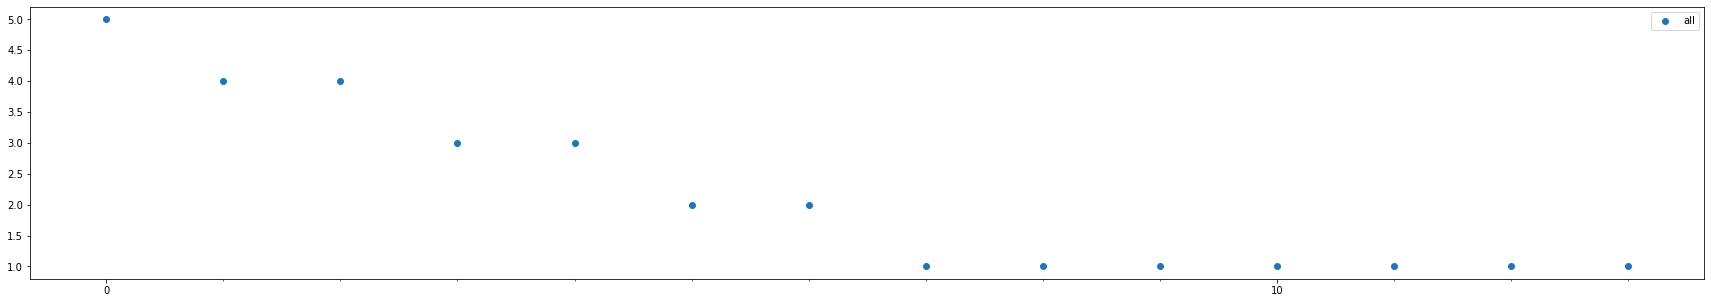

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


	30 Fisher Nodes:
	[(340, 5), (123, 4), (296, 4), (36, 3), (224, 3), (56, 2), (225, 2), (33, 1), (40, 1), (155, 1), (214, 1), (236, 1), (276, 1), (345, 1)]


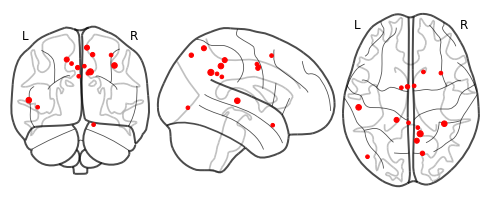

In [23]:
fig, ax = plt.subplots(figsize=(30,5))
plt.scatter(*zip(*[(str(a[0]),a[1]) for a in counter_nodes30.most_common(len(set(fisher_features_nodes30)))]))
plt.xticks(np.arange(0, len(set(fisher_features_nodes30)), step=1))
plt.legend(['all'])
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.show()

fNodes301=counter_nodes30.most_common(30)
nd301 = [a[0] for a in fNodes301]
ns301 = [a[1] for a in fNodes301]
viz.brain_viz_nodes(nodes=nd301,
                    title=
                    "\t%s Fisher Nodes:\n\t%s"
                    %(30,counter_nodes30.most_common(30)),
                    method='2d',node_size = ns301)

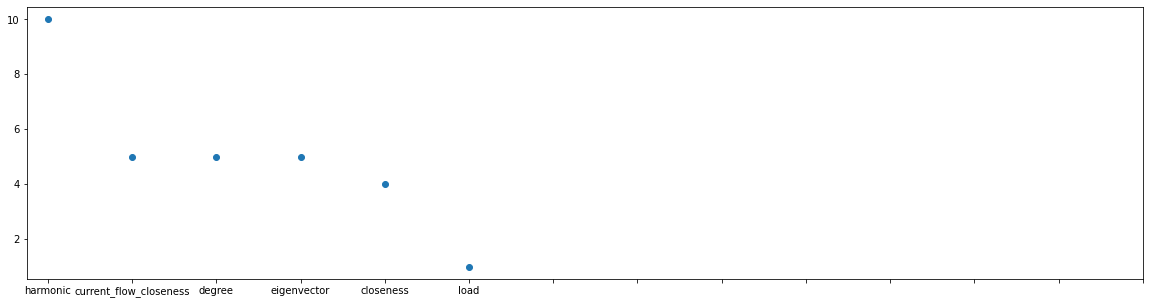

In [24]:
plt.figure(figsize=(20,5))
plt.scatter(*zip(*counter_measures30.most_common(14)))
plt.xticks(np.arange(0, 14, step=1))
plt.show()

In [25]:
print(counter_measures30.most_common(14),'\n\n',counter_nodes30.most_common(360))

[('harmonic', 10), ('current_flow_closeness', 5), ('degree', 5), ('eigenvector', 5), ('closeness', 4), ('load', 1)] 

 [(340, 5), (123, 4), (296, 4), (36, 3), (224, 3), (56, 2), (225, 2), (33, 1), (40, 1), (155, 1), (214, 1), (236, 1), (276, 1), (345, 1)]


In [26]:
fisher_features4          = features.iloc[:, idx[:int(len(idx)/4)]]
fisher_features_names4    = list(fisher_features4.T.index) 
fisher_features_names4    = [ffn for ffn in fisher_features_names4 if type(ffn)!=str]
fisher_features_nodes4    = [ffn[0] for ffn in fisher_features_names4]
fisher_features_measures4 = [ffn[1] for ffn in fisher_features_names4]
fisher_features_measures4.sort()
fisher_features_nodes4.sort()
counter_measures4=collections.Counter(fisher_features_measures4)
counter_nodes4=collections.Counter(fisher_features_nodes4)

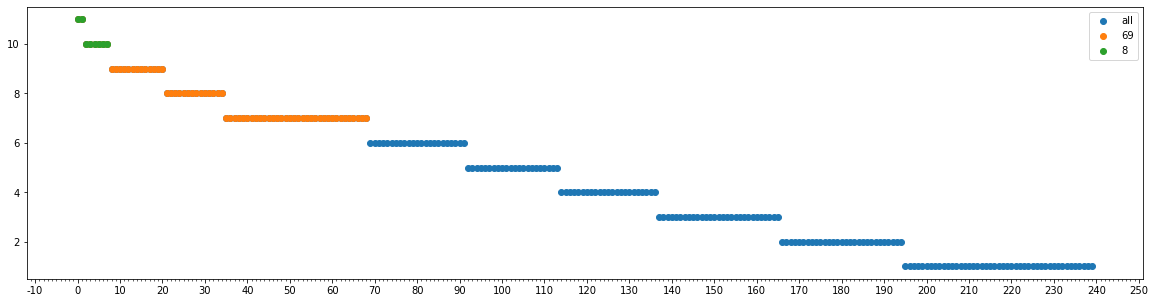

	8 Fisher Nodes:
	[(123, 11), (203, 11), (6, 10), (91, 10), (164, 10), (165, 10), (276, 10), (352, 10)]


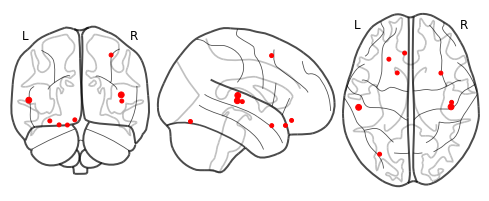

	69 Fisher Nodes:
	[(123, 11), (203, 11), (6, 10), (91, 10), (164, 10), (165, 10), (276, 10), (352, 10), (33, 9), (37, 9), (56, 9), (81, 9), (110, 9), (111, 9), (250, 9), (290, 9), (296, 9), (303, 9), (312, 9), (335, 9), (345, 9), (1, 8), (21, 8), (31, 8), (44, 8), (102, 8), (137, 8), (161, 8), (162, 8), (211, 8), (224, 8), (239, 8), (248, 8), (333, 8), (340, 8), (5, 7), (7, 7), (17, 7), (26, 7), (29, 7), (34, 7), (36, 7), (45, 7), (47, 7), (49, 7), (80, 7), (160, 7), (173, 7), (177, 7), (179, 7), (181, 7), (187, 7), (196, 7), (199, 7), (212, 7), (213, 7), (214, 7), (216, 7), (217, 7), (225, 7), (227, 7), (231, 7), (236, 7), (286, 7), (313, 7), (314, 7), (321, 7), (332, 7), (359, 7)]


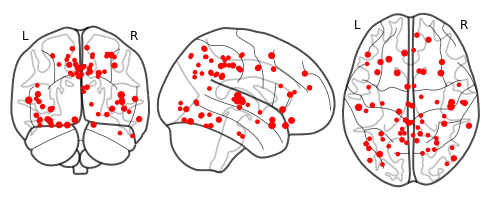

In [27]:
a1 = 69
a2 = 8
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(*zip(*[(str(a[0]),a[1]) for a in counter_nodes4.most_common(len(set(fisher_features_nodes4)))]))
plt.scatter(*zip(*[(str(a[0]),a[1]) for a in counter_nodes4.most_common(a1)]))
plt.scatter(*zip(*[(str(a[0]),a[1]) for a in counter_nodes4.most_common(a2)]))
plt.xticks(np.arange(0, len(set(fisher_features_nodes4)), step=1))
plt.legend(['all',a1,a2])
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.show()

fNodes41=counter_nodes4.most_common(a1)
fNodes42=counter_nodes4.most_common(a2)
nd42 = [a[0] for a in fNodes42]
ns42 = [a[1] for a in fNodes42]
viz.brain_viz_nodes(nodes=nd42,title="\t%s Fisher Nodes:\n\t%s"%(a2,counter_nodes4.most_common(a2)),method='2d',node_size = ns42)
plt.show()
nd41 = [a[0] for a in fNodes41]
ns41 = [a[1] for a in fNodes41]
viz.brain_viz_nodes(nodes=nd41,title="\t%s Fisher Nodes:\n\t%s"%(a1,counter_nodes4.most_common(a1)),method='2d',node_size = ns41)
enodes4_top = [np.array(counter_nodes4.most_common(a2)),'fisher-%d'%a2]
enodes4 = [np.array(counter_nodes4.most_common(a1)),'fisher-%d'%a1]

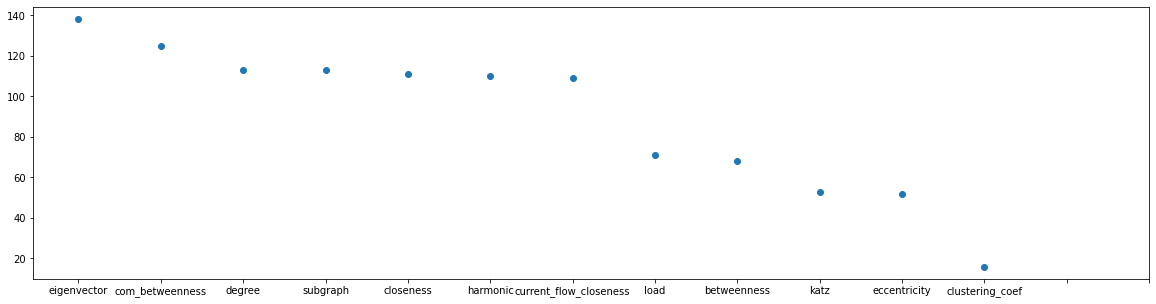

[('eigenvector', 138), ('com_betweenness', 125), ('degree', 113), ('subgraph', 113), ('closeness', 111), ('harmonic', 110), ('current_flow_closeness', 109), ('load', 71), ('betweenness', 68), ('katz', 53), ('eccentricity', 52), ('clustering_coef', 16)]


In [28]:
plt.figure(figsize=(20,5))
plt.scatter(*zip(*counter_measures4.most_common(14)))
plt.xticks(np.arange(0, 14, step=1))
plt.show()
print(counter_measures4.most_common(14))

### Feature Selection Using FSFS

Aplying FSFS algorithm on the first half of sorted features by the fisher score

#### classifier: LinearRegression

In [29]:
sfsLinReg = SFS(LinearRegression(),
                k_features=(35),
                forward=True,
                floating=False,
                scoring = 'r2',
                cv = 0)

In [30]:
sfsLinReg.fit(fisher_features_np, labels_np,tuple(fisher_features.columns))
sfsLinReg.k_feature_names_

((123, 'degree'),
 (276, 'current_flow_closeness'),
 (36, 'eigenvector'),
 (1, 'com_betweenness'),
 (21, 'eccentricity'),
 (177, 'katz'),
 (199, 'com_betweenness'),
 (171, 'eigenvector'),
 (164, 'degree'),
 (56, 'load'),
 (155, 'eccentricity'),
 (310, 'subgraph'),
 (169, 'closeness'),
 (137, 'katz'),
 (140, 'subgraph'),
 (314, 'current_flow_closeness'),
 (153, 'katz'),
 (8, 'current_flow_closeness'),
 (23, 'closeness'),
 (247, 'closeness'),
 (258, 'clustering_coef'),
 (65, 'closeness'),
 (274, 'com_betweenness'),
 (336, 'current_flow_closeness'),
 (126, 'subgraph'),
 (70, 'harmonic'),
 (219, 'katz'),
 (298, 'eccentricity'),
 (87, 'clustering_coef'),
 (7, 'clustering_coef'),
 (91, 'katz'),
 (167, 'harmonic'),
 (248, 'katz'),
 (323, 'clustering_coef'),
 (324, 'subgraph'))

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


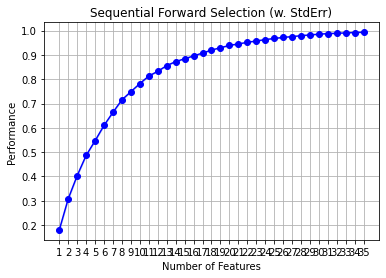

In [31]:
figLR = plot_sfs(sfsLinReg.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [32]:
sfsLinReg.get_metric_dict()

{1: {'feature_idx': (7,),
  'cv_scores': array([0.17999261]),
  'avg_score': 0.1799926072677277,
  'feature_names': ((123, 'degree'),),
  'ci_bound': nan,
  'std_dev': 0.0,
  'std_err': nan},
 2: {'feature_idx': (7, 47),
  'cv_scores': array([0.3083053]),
  'avg_score': 0.3083053009072413,
  'feature_names': ((123, 'degree'), (36, 'eigenvector')),
  'ci_bound': nan,
  'std_dev': 0.0,
  'std_err': nan},
 3: {'feature_idx': (7, 47, 804),
  'cv_scores': array([0.40346813]),
  'avg_score': 0.40346812619480965,
  'feature_names': ((123, 'degree'),
   (36, 'eigenvector'),
   (155, 'eccentricity')),
  'ci_bound': nan,
  'std_dev': 0.0,
  'std_err': nan},
 4: {'feature_idx': (7, 47, 160, 804),
  'cv_scores': array([0.48648779]),
  'avg_score': 0.48648779234309303,
  'feature_names': ((123, 'degree'),
   (36, 'eigenvector'),
   (1, 'com_betweenness'),
   (155, 'eccentricity')),
  'ci_bound': nan,
  'std_dev': 0.0,
  'std_err': nan},
 5: {'feature_idx': (7, 47, 160, 456, 804),
  'cv_scores': arr

In [33]:
fisher_features_names_sfsLR    = list(sfsLinReg.k_feature_names_)
fisher_features_names_sfsLR    = [ffn for ffn in fisher_features_names_sfsLR if type(ffn)!=str]
fisher_features_nodes_sfsLR    = [ffn[0] for ffn in fisher_features_names_sfsLR]
fisher_features_measures_sfsLR = [ffn[1] for ffn in fisher_features_names_sfsLR]
fisher_features_measures_sfsLR.sort()
fisher_features_nodes_sfsLR.sort()
counter_measures_sfsLR=collections.Counter(fisher_features_measures_sfsLR)
counter_nodes_sfsLR=collections.Counter(fisher_features_nodes_sfsLR)

In [34]:
enodes_sfsLR = [np.array(counter_nodes_sfsLR.most_common(360)),
                'sfsLR-%d'%len(counter_nodes_sfsLR.most_common(360))]

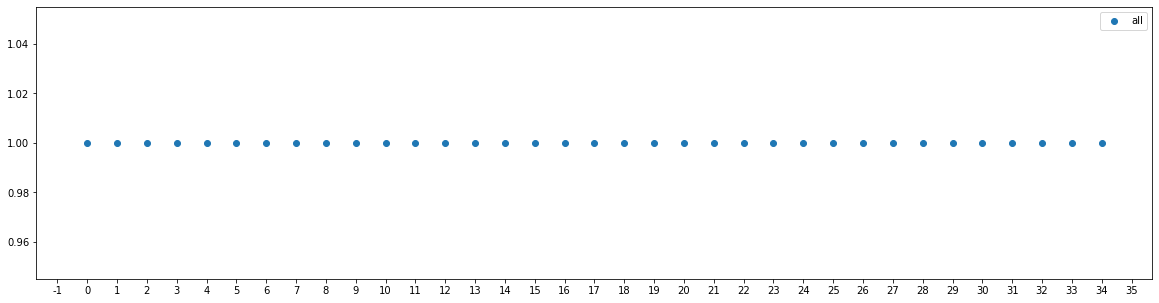

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


	35 Nodes:
	[(1, 1), (7, 1), (8, 1), (21, 1), (23, 1), (36, 1), (56, 1), (65, 1), (70, 1), (87, 1), (91, 1), (123, 1), (126, 1), (137, 1), (140, 1), (153, 1), (155, 1), (164, 1), (167, 1), (169, 1), (171, 1), (177, 1), (199, 1), (219, 1), (247, 1), (248, 1), (258, 1), (274, 1), (276, 1), (298, 1), (310, 1), (314, 1), (323, 1), (324, 1), (336, 1)]


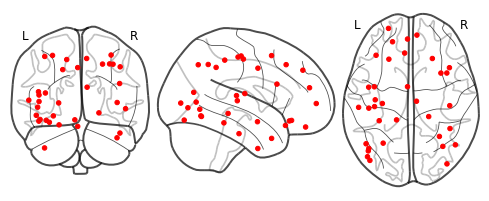

In [35]:
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(*zip(*[(str(a[0]),a[1]) for a in counter_nodes_sfsLR.most_common(50)]))
plt.xticks(np.arange(0, len(set(fisher_features_nodes_sfsLR)), step=1))
plt.legend(['all','6'])
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.show()

fNodes_sfsLR=counter_nodes_sfsLR.most_common(50)
nd_sfsLR = [a[0] for a in fNodes_sfsLR]
ns_sfsLR = [a[1] for a in fNodes_sfsLR]
viz.brain_viz_nodes(nodes=nd_sfsLR,
                    title=
                    "\t%d Nodes:\n\t%s"%(len(nd_sfsLR),
                                         counter_nodes_sfsLR.most_common(360)),
                    method='2d',node_size = ns_sfsLR)

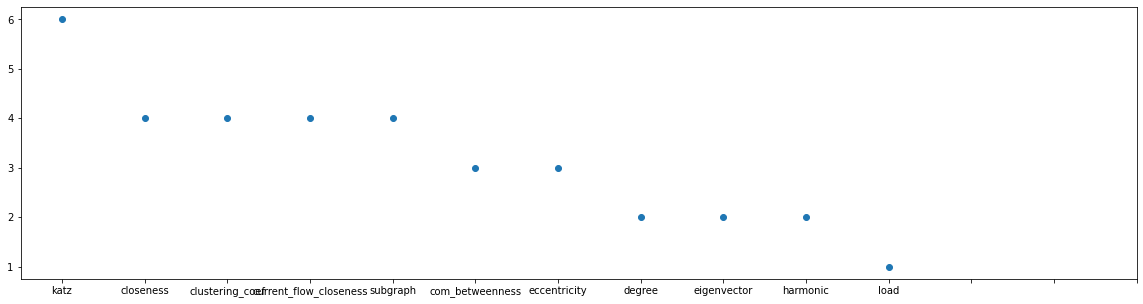

[('katz', 6), ('closeness', 4), ('clustering_coef', 4), ('current_flow_closeness', 4), ('subgraph', 4), ('com_betweenness', 3), ('eccentricity', 3), ('degree', 2), ('eigenvector', 2), ('harmonic', 2), ('load', 1)]


In [36]:
plt.figure(figsize=(20,5))
plt.scatter(*zip(*counter_measures_sfsLR.most_common(50)))
plt.xticks(np.arange(0, 14, step=1))
plt.show()
print(counter_measures_sfsLR.most_common(14))

Selecting effective nodes and measures based on FSF algorithm (linear regression classifier)

#### SVM

In [37]:
svc = svm.SVC(random_state=0, probability=True)
sfsSVC = SFS(svc, 
           k_features=17,
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=0)

In [38]:
sfsSVC.fit(fisher_features_np, labels_np,tuple(fisher_features.columns))
sfsSVC.k_feature_names_ 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2158 out of 2158 | elapsed:    7.5s finished

[2020-10-02 20:19:24] Features: 1/17 -- score: 0.46875[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2157 out of 2157 | elapsed:    7.6s finished

[2020-10-02 20:19:32] Features: 2/17 -- score: 0.5625[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2156 out of 2156 | elapsed:    7.8s finished

[2020-10-02 20:19:40] Features: 3/17 -- score: 0.6666666666666666[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | e

((179, 'com_betweenness'),
 (224, 'subgraph'),
 (290, 'eigenvector'),
 (97, 'load'),
 (117, 'subgraph'),
 (31, 'com_betweenness'),
 (276, 'com_betweenness'),
 (137, 'com_betweenness'),
 (276, 'load'),
 (274, 'load'),
 (6, 'subgraph'),
 (65, 'com_betweenness'),
 (232, 'load'),
 (319, 'eigenvector'),
 (239, 'betweenness'),
 (172, 'load'),
 (237, 'load'))

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


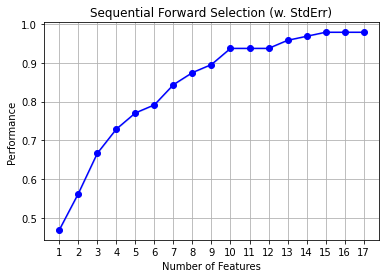

In [39]:
figSVC = plot_sfs(sfsSVC.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [40]:
sfsSVC.subsets_

{1: {'feature_idx': (202,),
  'cv_scores': array([0.46875]),
  'avg_score': 0.46875,
  'feature_names': ((97, 'load'),)},
 2: {'feature_idx': (81, 202),
  'cv_scores': array([0.5625]),
  'avg_score': 0.5625,
  'feature_names': ((224, 'subgraph'), (97, 'load'))},
 3: {'feature_idx': (81, 202, 760),
  'cv_scores': array([0.66666667]),
  'avg_score': 0.6666666666666666,
  'feature_names': ((224, 'subgraph'), (97, 'load'), (6, 'subgraph'))},
 4: {'feature_idx': (81, 202, 760, 1444),
  'cv_scores': array([0.72916667]),
  'avg_score': 0.7291666666666666,
  'feature_names': ((224, 'subgraph'),
   (97, 'load'),
   (6, 'subgraph'),
   (232, 'load'))},
 5: {'feature_idx': (81, 202, 760, 941, 1444),
  'cv_scores': array([0.77083333]),
  'avg_score': 0.7708333333333334,
  'feature_names': ((224, 'subgraph'),
   (97, 'load'),
   (6, 'subgraph'),
   (65, 'com_betweenness'),
   (232, 'load'))},
 6: {'feature_idx': (81, 202, 760, 941, 1444, 1960),
  'cv_scores': array([0.79166667]),
  'avg_score': 0.7

In [41]:
fisher_features_names_sfsSVM = list(sfsSVC.k_feature_names_)
fisher_features_names_sfsSVM = [ffn for ffn in fisher_features_names_sfsSVM if type(ffn)!=str]
fisher_features_nodes_sfsSVM = [ffn[0] for ffn in fisher_features_names_sfsSVM]
fisher_features_measures_sfsSVM = [ffn[1] for ffn in fisher_features_names_sfsSVM]
fisher_features_measures_sfsSVM.sort()
fisher_features_nodes_sfsSVM.sort()
counter_measures_sfsSVM=collections.Counter(fisher_features_measures_sfsSVM)
counter_nodes_sfsSVM=collections.Counter(fisher_features_nodes_sfsSVM)

In [42]:
enodes_sfsSVM = [np.array(counter_nodes_sfsSVM.most_common(360)),
                'sfsSVM-%d'%len(counter_nodes_sfsSVM.most_common(360))]

<Figure size 1440x360 with 0 Axes>

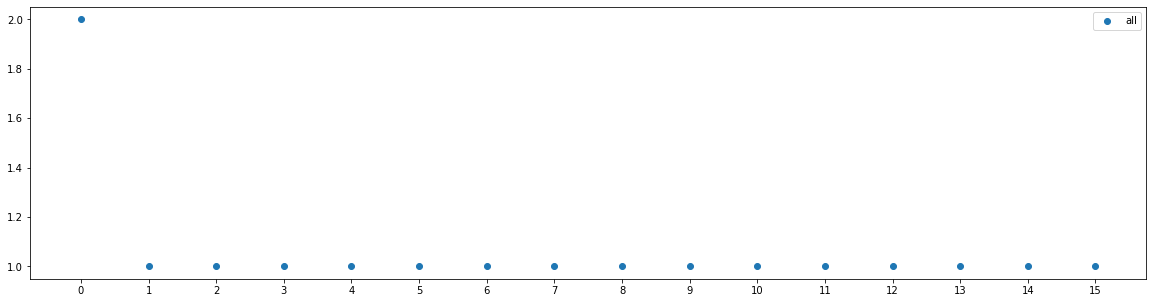

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


	16 Nodes:
	[(276, 2), (6, 1), (31, 1), (65, 1), (97, 1), (117, 1), (137, 1), (172, 1), (179, 1), (224, 1), (232, 1), (237, 1), (239, 1), (274, 1), (290, 1), (319, 1)]


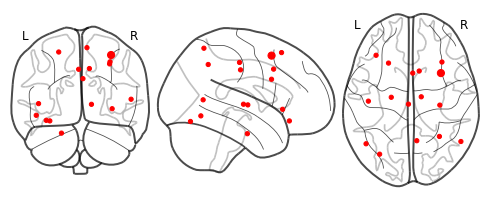

In [43]:
plt.figure(figsize=(20,5))
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(*zip(*[(str(a[0]),a[1]) for a in counter_nodes_sfsSVM.most_common(50)]))
plt.xticks(np.arange(0, len(set(fisher_features_nodes_sfsSVM)), step=1))
plt.legend(['all','6'])
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.show()

fNodes_sfsSVM=counter_nodes_sfsSVM.most_common(50)
nd_sfsSVM = [a[0] for a in fNodes_sfsSVM]
ns_sfsSVM = [a[1] for a in fNodes_sfsSVM]
viz.brain_viz_nodes(nodes=nd_sfsSVM,
                    title="\t%d Nodes:\n\t%s"
                    %(len(nd_sfsSVM),counter_nodes_sfsSVM.most_common(360)), 
                      method='2d',node_size = ns_sfsSVM)

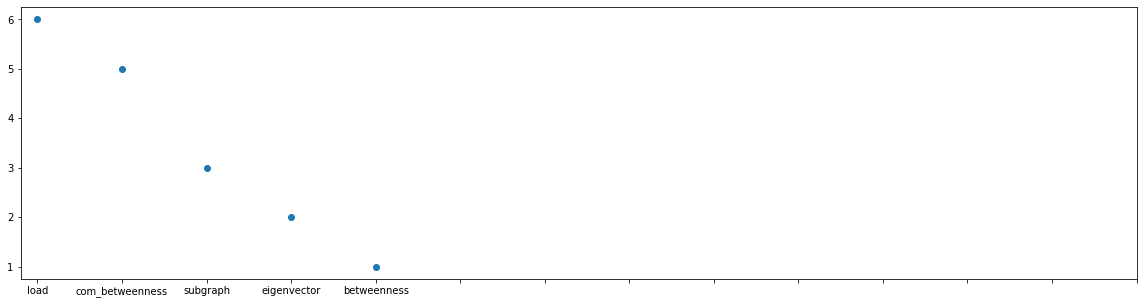

[('load', 6), ('com_betweenness', 5), ('subgraph', 3), ('eigenvector', 2), ('betweenness', 1)]


In [44]:
plt.figure(figsize=(20,5))
plt.scatter(*zip(*counter_measures_sfsSVM.most_common(50)))
plt.xticks(np.arange(0, 14, step=1))
plt.show()
print(counter_measures_sfsSVM.most_common(14))

### Link Selection Based on Correlation Matrices

In [45]:
cols = subjects_list[subjects_groups[0]].copy()
sep=[len(subjects_list[subjects_groups[0]])]
for i in range(1,len(subjects_groups)):
    cols.extend(subjects_list[subjects_groups[i]])
    sep.append(len(subjects_list[subjects_groups[i]]) + sep[i-1])
sep.insert(0,0)

In [49]:
import glob
dfM = {}
for i in range(len(subjects_groups)):
    for s in cols[sep[i]:sep[i+1]]:
        if ct == 'glasso':
            if sign=='both':
                filesnp = glob.glob(rootdir + "/data/04_correlations/corr-%s/all/ds-%s/*%s*.npy"
                                    %(ct,ds,s))
            M  = np.load(filesnp[0])
        else:
            M = gla.read_M(s,ds,ct)
        df = pd.DataFrame(data=M, index=range(np.shape(M)[0]), columns=range(np.shape(M)[0]))
        df = df.drop([119],axis=1)
        df = df.drop([119],axis=0)
        df = df.stack().to_frame()
        try:
            dfM[subjects_groups[i]] = pd.concat([dfM[subjects_groups[i]],df],axis=1)
        except KeyError:
            dfM[subjects_groups[i]] = df.copy()
    try:
        dfM['all'] = pd.concat([dfM['all'],dfM[subjects_groups[i]]],axis=1)
    except KeyError:
        dfM['all'] = dfM[subjects_groups[i]].copy()

#### Fisher

In [50]:
score = fisher_score.fisher_score(dfM['all'].T.values, labels_np)
idx   = fisher_score.feature_ranking(score)

In [51]:
fisher_features260       = dfM['all'].T.iloc[:, idx[:520]]
fisher_features_names260 = list(fisher_features260.T.index) 
fisher_features_1260     = [ffn[0] for ffn in fisher_features_names260]
fisher_features_nodes260 = [ffn[1] for ffn in fisher_features_names260]
fisher_features_nodes260.extend(fisher_features_1260)
fisher_features_nodes260.sort()
counter_nodes260=collections.Counter(fisher_features_nodes260)

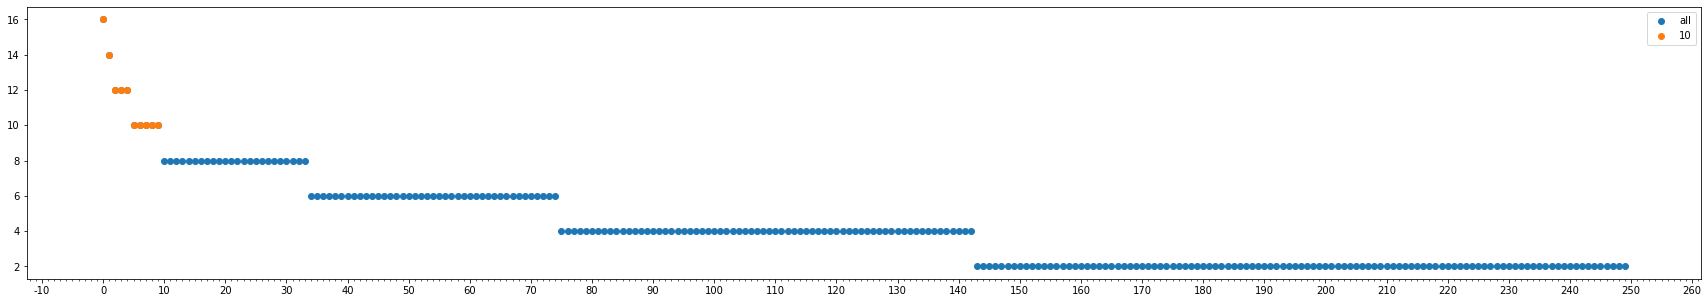

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


	10 Links:
	[(335, 16), (311, 14), (14, 12), (52, 12), (350, 12), (4, 10), (132, 10), (140, 10), (183, 10), (320, 10)]


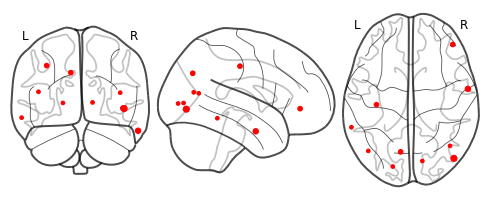

In [52]:
a2 = 10
fig, ax = plt.subplots(figsize=(30,5))
plt.scatter(*zip(*[(str(a[0]),a[1]) for a in counter_nodes260.most_common(len(set(fisher_features_nodes260)))]))
plt.scatter(*zip(*[(str(a[0]),a[1]) for a in counter_nodes260.most_common(a2)]))

plt.xticks(np.arange(0, len(set(fisher_features_nodes260)), step=1))
plt.legend(['all',a2])
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.show()

fNodes2602=counter_nodes260.most_common(a2)
nd2602 = [a[0] for a in fNodes2602]
ns2602 = [a[1] for a in fNodes2602]
viz.brain_viz_nodes(nodes=nd2602,title="\t%s Links:\n\t%s"%(a2,counter_nodes260.most_common(a2)),method='2d',node_size = ns2602)
plt.show()

In [53]:
fisher_features_links200 = dfM['all'].T.iloc[:, idx[:200]]
fisher_features_names_links200 = list(fisher_features_links200.T.index) 
fisher_features_names_links200

[(263, 88),
 (88, 263),
 (10, 73),
 (73, 10),
 (351, 4),
 (4, 351),
 (208, 29),
 (29, 208),
 (116, 258),
 (258, 116),
 (333, 160),
 (160, 333),
 (73, 107),
 (107, 73),
 (115, 220),
 (220, 115),
 (28, 303),
 (303, 28),
 (51, 115),
 (115, 51),
 (264, 82),
 (82, 264),
 (140, 184),
 (184, 140),
 (4, 325),
 (325, 4),
 (277, 97),
 (97, 277),
 (113, 263),
 (263, 113),
 (81, 108),
 (108, 81),
 (265, 91),
 (91, 265),
 (175, 311),
 (311, 175),
 (164, 12),
 (12, 164),
 (10, 233),
 (233, 10),
 (191, 228),
 (228, 191),
 (260, 253),
 (253, 260),
 (198, 336),
 (336, 198),
 (186, 3),
 (3, 186),
 (291, 334),
 (334, 291),
 (69, 170),
 (170, 69),
 (325, 184),
 (184, 325),
 (335, 157),
 (157, 335),
 (290, 350),
 (350, 290),
 (51, 46),
 (46, 51),
 (228, 189),
 (189, 228),
 (50, 72),
 (72, 50),
 (335, 14),
 (14, 335),
 (329, 212),
 (212, 329),
 (200, 22),
 (22, 200),
 (247, 242),
 (242, 247),
 (115, 356),
 (356, 115),
 (158, 152),
 (152, 158),
 (258, 296),
 (296, 258),
 (316, 130),
 (130, 316),
 (208, 247),

In [54]:
elinks_200 = [np.array(fisher_features_names_links200),
              'links-fisher-%d'
              %int(len(fisher_features_names_links200)/2)]

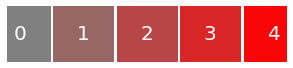

Link Selection Based on Correlation Matrices


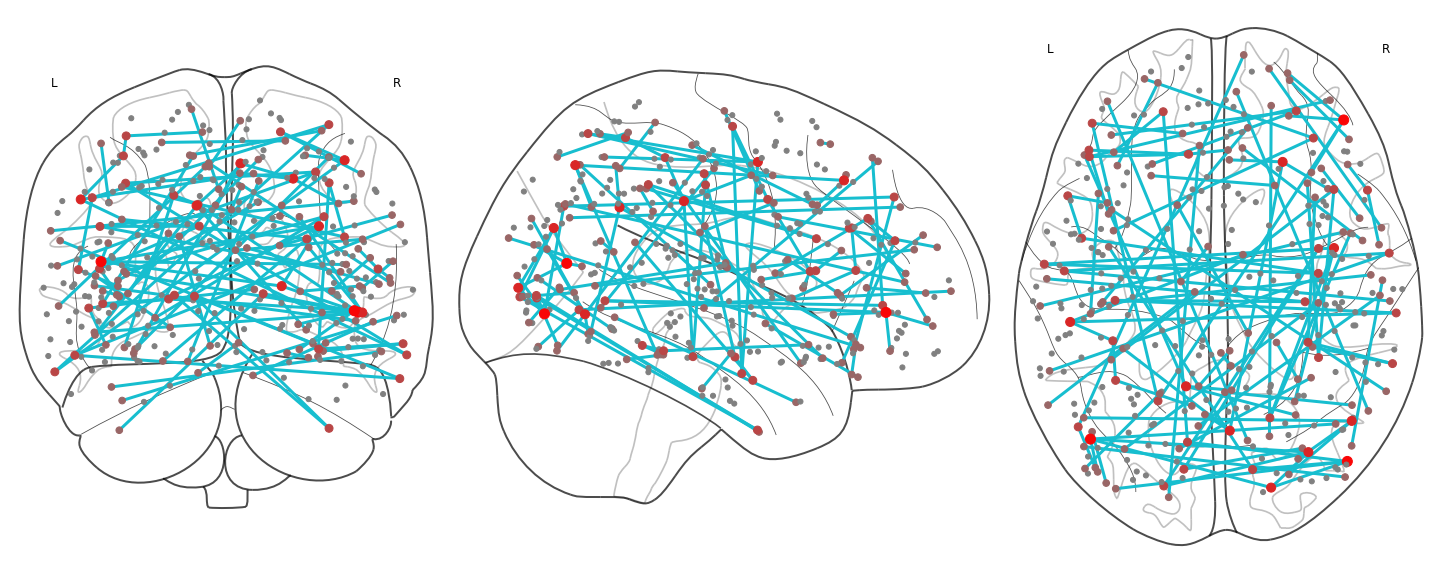

In [55]:
M = np.zeros((360,360))
for i in fisher_features_names_links200:
    M[i[0],i[1]]=1
viz.brain_viz_from_path(cm = M ,
                        title = 'Link Selection Based on Correlation Matrices',
                        density = 1, method = '2d')

#### PCA

In [56]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

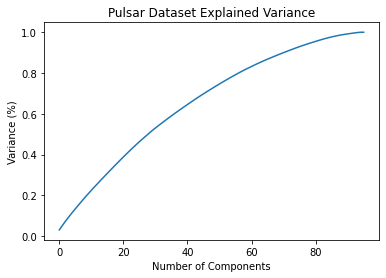

In [57]:
x = StandardScaler().fit_transform(dfM['all'].T)
pca = PCA().fit(x)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

### Save

In [58]:
os.system('mkdir -p %s/data/07_features/tm-%s/corr-%s/ds-%s'%(rootdir,tm,ct,ds))

np.save("%s/data/07_features/tm-%s/corr-%s/ds-%s/method-%s_ds-%s_corr-%s-%s_tm-%s"
            %(rootdir,tm,ct,ds,enodes4_top[1],ds,ct,sgn,tm), enodes4_top[0])
        
np.save("%s/data/07_features/tm-%s/corr-%s/ds-%s/method-%s_ds-%s_corr-%s-%s_tm-%s"
            %(rootdir,tm,ct,ds,enodes4[1],ds,ct,sgn,tm), enodes4[0])
        
np.save("%s/data/07_features/tm-%s/corr-%s/ds-%s/method-%s_ds-%s_corr-%s-%s_tm-%s"
            %(rootdir,tm,ct,ds,enodes_sfsLR[1],ds,ct,sgn,tm), enodes_sfsLR[0])
        
np.save("%s/data/07_features/tm-%s/corr-%s/ds-%s/method-%s_ds-%s_corr-%s-%s_tm-%s"
            %(rootdir,tm,ct,ds,enodes_sfsSVM[1],ds,ct,sgn,tm), enodes_sfsSVM[0])

np.save("%s/data/07_features/tm-%s/corr-%s/ds-%s/method-%s_ds-%s_corr-%s-%s_tm-%s"
            %(rootdir,tm,ct,ds,elinks_200[1],ds,ct,sgn,tm), elinks_200[0])

#### Save the notebook

In [59]:
os.system("mkdir -p %s/docs/feature_selection"%(rootdir))

0

In [63]:
os.system("cp %s/notebooks/08_feature_selection-Copy2.ipynb %s/docs/feature_selection/%s-%s-corr_ds-%s_tm-%s.ipynb"
          %(rootdir,rootdir,ct,sgn,ds,tm))

0